In [1]:
using Turing
using LimberJack
using CSV
using NPZ
using Plots
using FITSIO
using Plots
using LinearAlgebra
using Distributed
using StatsPlots
using Optim
using ForwardDiff
using BenchmarkTools

In [2]:
files = npzread("../data/DESY1_cls/Cls_meta.npz")
Cls_meta = cls_meta(files)

cls_meta{Vector{Vector{Int64}}}([[1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3]], [[1, 0, 1, 0], [1, 1, 1, 1], [1, 2, 1, 2], [1, 3, 1, 3], [1, 4, 1, 4], [1, 0, 2, 0], [1, 0, 2, 1], [1, 0, 2, 2], [1, 0, 2, 3], [1, 1, 2, 0]  …  [2, 0, 2, 0], [2, 0, 2, 1], [2, 0, 2, 2], [2, 0, 2, 3], [2, 1, 2, 1], [2, 1, 2, 2], [2, 1, 2, 3], [2, 2, 2, 2], [2, 2, 2, 3], [2, 3, 2, 3]], [[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [1, 6], [1, 7], [1, 8], [1, 9], [2, 6]  …  [6, 6], [6, 7], [6, 8], [6, 9], [7, 7], [7, 8], [7, 9], [8, 8], [8, 9], [9, 9]])

In [3]:
cov_tot = files["cov"]
inv_cov_tot = files["inv_cov"]
data_vector = files["cls"];

In [4]:
#                Omega_b,           Omega_c          n_s,                 h,
#                DESgc__0_gc_b,     DESgc__1_gc_b,   DESgc__2_gc_b,    DESgc__3_gc_b,    DESgc__4_gc_b,
#                DESgc__0_dz,      DESgc__1_dz,      DESgc__2_dz,      DESgc__3_dz,      DESgc__4_dz,
#                wl_ia_A,          wl_ia_eta, 
#                DESwl__0_wl_m,    DESwl__1_wl_m,    DESwl__2_wl_m,    DESwl__3_wl_m,
#                DESwl__0_dz,      DESwl__1_dz,      DESwl__2_dz,      DESwl__3_dz,
#                sigma_8,          Omega_m
carlos_params1 = [4.426868e-02,     2.093138e-01,     8.963611e-01,     8.495440e-01,
                 1.343888e+00,    1.639047e+00,      1.597174e+00,     1.944583e+00,     2.007245e+00,
                -4.679383e-03,   -2.839996e-03,      1.771571e-03,     1.197051e-03,    -5.199799e-03,
                 2.389208e-01,   -6.435288e-01, 
                 1.802722e-03,   -5.508994e-03,     1.952514e-02,    -1.117726e-03,
                -1.744083e-02,    6.777779e-03,    -1.097939e-03,    -4.912315e-03,
                 8.536883e-01,    2.535825e-01];

In [5]:
cls_carlos = npzread("/home/jaime/PhD/LimberJack.jl/chains/cl_cross_corr_v3_DES_2/cl_cross_corr_bestfit_info.npz");

In [6]:
pars = carlos_params1
nuisances = Dict("b0" => pars[5],
                 "b1" => pars[6],
                 "b2" => pars[7],
                 "b3" => pars[8],
                 "b4" => pars[9],
                 "dz_g0" => pars[10],
                 "dz_g1" => pars[11],
                 "dz_g2" => pars[12],
                 "dz_g3" => pars[13],
                 "dz_g4" => pars[14],
                 "dz_k0" => pars[21],
                 "dz_k1" => pars[22],
                 "dz_k2" => pars[23],
                 "dz_k3" => pars[24],
                 "m0" => pars[17],
                 "m1" => pars[18],
                 "m2" => pars[19],
                 "m3" => pars[20],
                 "A_IA" => pars[15],
                 "alpha_IA" => pars[16]);

In [7]:
function make_cls(pars; mode="linear")
    nuisances = Dict("b0" => pars[5],
                     "b1" => pars[6],
                     "b2" => pars[7],
                     "b3" => pars[8],
                     "b4" => pars[9],
                     "dz_g0" => pars[10],
                     "dz_g1" => pars[11],
                     "dz_g2" => pars[12],
                     "dz_g3" => pars[13],
                     "dz_g4" => pars[14],
                     "dz_k0" => pars[21],
                     "dz_k1" => pars[22],
                     "dz_k2" => pars[23],
                     "dz_k3" => pars[24],
                     "m0" => pars[17],
                     "m1" => pars[18],
                     "m2" => pars[19],
                     "m3" => pars[20],
                     "A_IA" => pars[15],
                     "alpha_IA" => pars[16])

    Ωm = pars[26]
    Ωb = pars[1]
    h = pars[4]
    ns = pars[3]
    s8 = pars[25]
    cosmology = LimberJack.Cosmology(Ωm, Ωb, h, ns, s8, tk_mode="EisHu", Pk_mode="Halofit")
    
    if mode=="linear"
        cls = vcat(Theory(cosmology, nuisances, Cls_meta, files)...)
    else
        cls = vcat(Theory_parallel(cosmology, nuisances, Cls_meta, files)...)
    end
    
    return cls
end

make_cls (generic function with 1 method)

In [8]:
@benchmark make_cls(carlos_params1, mode="linear")

BenchmarkTools.Trial: 
  memory estimate:  717.03 MiB
  allocs estimate:  43685545
  --------------
  minimum time:     1.525 s (6.01% GC)
  median time:      1.556 s (6.25% GC)
  mean time:        1.574 s (6.23% GC)
  maximum time:     1.658 s (5.98% GC)
  --------------
  samples:          4
  evals/sample:     1

In [9]:
@time [make_cls(carlos_params1, mode="linear") for i in 1:10]

 15.467714 seconds (436.91 M allocations: 7.005 GiB, 6.38% gc time, 0.31% compilation time)


10-element Vector{Vector{Float64}}:
 [0.00019878054597087568, 8.13318507958567e-5, 4.13999781319054e-5, 2.5956011253713785e-5, 1.8060419156355993e-5, 0.00011315355228614883, 6.075356974541723e-5, 3.9016695376984714e-5, 2.4025861039667573e-5, 1.746979673562369e-5  …  5.492164002058151e-10, 4.722511445750479e-10, 4.057194776978221e-10, 3.4797465219096675e-10, 2.977471751602306e-10, 2.5381685684179695e-10, 2.154322086898068e-10, 1.8194711530074317e-10, 1.5279081401210278e-10, 1.2754801396685722e-10]
 [0.00019878054597087568, 8.13318507958567e-5, 4.13999781319054e-5, 2.5956011253713785e-5, 1.8060419156355993e-5, 0.00011315355228614883, 6.075356974541723e-5, 3.9016695376984714e-5, 2.4025861039667573e-5, 1.746979673562369e-5  …  5.492164002058151e-10, 4.722511445750479e-10, 4.057194776978221e-10, 3.4797465219096675e-10, 2.977471751602306e-10, 2.5381685684179695e-10, 2.154322086898068e-10, 1.8194711530074317e-10, 1.5279081401210278e-10, 1.2754801396685722e-10]
 [0.00019878054597087568, 8.1331

In [10]:
@benchmark make_cls(carlos_params1, mode="parallel")

BenchmarkTools.Trial: 
  memory estimate:  717.03 MiB
  allocs estimate:  43685922
  --------------
  minimum time:     1.341 s (14.25% GC)
  median time:      1.416 s (13.71% GC)
  mean time:        1.401 s (13.92% GC)
  maximum time:     1.430 s (13.78% GC)
  --------------
  samples:          4
  evals/sample:     1

In [11]:
@time [make_cls(carlos_params1, mode="parallel") for i in 1:10]

 12.861098 seconds (436.92 M allocations: 7.005 GiB, 14.81% gc time, 0.44% compilation time)


10-element Vector{Vector{Real}}:
 [0.00019878054597087568, 8.13318507958567e-5, 4.13999781319054e-5, 2.5956011253713785e-5, 1.8060419156355993e-5, 0.00011315355228614883, 6.075356974541723e-5, 3.9016695376984714e-5, 2.4025861039667573e-5, 1.746979673562369e-5  …  5.492164002058151e-10, 4.722511445750479e-10, 4.057194776978221e-10, 3.4797465219096675e-10, 2.977471751602306e-10, 2.5381685684179695e-10, 2.154322086898068e-10, 1.8194711530074317e-10, 1.5279081401210278e-10, 1.2754801396685722e-10]
 [0.00019878054597087568, 8.13318507958567e-5, 4.13999781319054e-5, 2.5956011253713785e-5, 1.8060419156355993e-5, 0.00011315355228614883, 6.075356974541723e-5, 3.9016695376984714e-5, 2.4025861039667573e-5, 1.746979673562369e-5  …  5.492164002058151e-10, 4.722511445750479e-10, 4.057194776978221e-10, 3.4797465219096675e-10, 2.977471751602306e-10, 2.5381685684179695e-10, 2.154322086898068e-10, 1.8194711530074317e-10, 1.5279081401210278e-10, 1.2754801396685722e-10]
 [0.00019878054597087568, 8.1331850

In [12]:
cls_jaime1 = make_cls(carlos_params1, mode="linear");

In [13]:
cls_jaime2 = make_cls(carlos_params1, mode="parallel");

In [14]:
compa1 = @. abs(cls_carlos["cls"]-cls_jaime1)/cls_carlos["cls"];

In [15]:
err = diag(cov_tot)
loss_jaime1 = @. abs(data_vector .- cls_jaime1) ./ err ;
loss_carlos = @. abs(data_vector .- cls_carlos["cls"]) ./ err ;

In [16]:
chi2_carlos = cls_carlos["chi2"]

-503.9984892644933

In [17]:
chi2_jaime1 = - dot((cls_jaime1 .- data_vector), inv_cov_tot  * (cls_jaime1 .- data_vector))
chi2_jaime2 = - dot((cls_jaime2 .- data_vector), inv_cov_tot  * (cls_jaime2 .- data_vector))
println(chi2_jaime1)
println(chi2_jaime2)

-503.76840278463385
-503.76840278463385


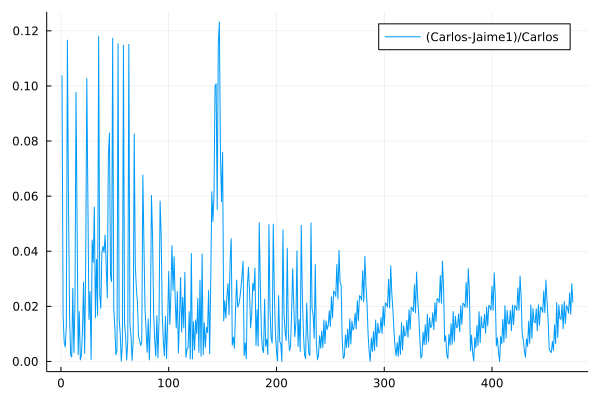

In [22]:
plot(compa1, label="(Carlos-Jaime1)/Carlos")

In [19]:
@model function model(data_vector::Vector{Float64})
    Ωm ~ Uniform(0.1, 0.5)
    h = 0.67 #~ Uniform(0.6, 0.8)
    s8 ~ Uniform(0.6, 1.0)
    
    b0 = 1.41 #~ Uniform(1.0, 3.0)
    b1 = 1.62 #~ Uniform(1.0, 3.0)
    b2 = 1.60 #~ Uniform(1.0, 3.0)
    b3 = 1.92 #~ Uniform(1.0, 3.0)
    b4 = 2.00 #~ Uniform(1.0, 3.0)
    
    nuisances = Dict("b0" => b0,
                     "b1" => b1,
                     "b2" => b2,
                     "b3" => b3,
                     "b4" => b4)
    
    cosmology = LimberJack.Cosmology(Ωm, 0.05, h, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = vcat(Theory(cosmology, nuisances, Cls_meta, files)...)
    data_vector ~ MvNormal(theory, cov_tot)
    return data_vector
end;

In [20]:
@model function model_parallel(data_vector::Vector{Float64})
    Ωm ~ Uniform(0.1, 0.5)
    h = 0.67 #~ Uniform(0.6, 0.8)
    s8 ~ Uniform(0.6, 1.0)
    
    b0 = 1.41 #~ Uniform(1.0, 3.0)
    b1 = 1.62 #~ Uniform(1.0, 3.0)
    b2 = 1.60 #~ Uniform(1.0, 3.0)
    b3 = 1.92 #~ Uniform(1.0, 3.0)
    b4 = 2.00 #~ Uniform(1.0, 3.0)
    
    nuisances = Dict("b0" => b0,
                     "b1" => b1,
                     "b2" => b2,
                     "b3" => b3,
                     "b4" => b4)
    
    cosmology = LimberJack.Cosmology(Ωm, 0.05, h, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    
    theory = vcat(Theory_parallel(cosmology, nuisances, Cls_meta, files)...)
    data_vector ~ MvNormal(theory, cov_tot)
    return data_vector
end;

In [21]:
iterations = 300
nadapts = 100

chain1 = sample(model(data_vector), MH(), iterations,
            nadapt=nadapts, progress=true; save_state=true);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:28


LoadError: InterruptException:

In [23]:
chain2 = sample(model_parallel(data_vector), MH(), iterations,
            nadapt=nadapts, progress=true; save_state=true);

LoadError: InterruptException:

In [24]:
chain3 = sample(model(data_vector), NUTS(100, 0.5), iterations,
            nadapt=nadapts, progress=true; save_state=true);

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/jaime/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/jaime/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:37


LoadError: InterruptException:

In [ ]:
chain4 = sample(model_parallel(data_vector), NUTS(100, 0.5), iterations,
            nadapt=nadapts, progress=true; save_state=true);

In [ ]:
iterations = 1000
adaptation = 100
TAP = 0.6

NUTS_chain = sample(model(data_vector), NUTS(adaptation, TAP),
            iterations, progress=true; save_state=true);

In [ ]:
describe(NUTS_chain)[1]

In [ ]:
plot(NUTS_chain)